# Лабораторная работа №1. Логистическая регрессия в качестве нейронной сети
Данные: В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.
Данные можно скачать по ссылке: 
https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных); https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке: http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

Задание 1. Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python;

Задание 2. Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (В данной задаче 10 классов).

Задание 3. Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений);

Задание 4. Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.

Задание 5. Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). Для построения классификатора можете использовать библиотеку SkLearn (http://scikit-learn.org).

In [2]:
import hashlib
import os
from collections import Counter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

image_dir = './notMNIST_large'
img_height, img_width = 28, 28
s = img_height * img_width

In [3]:
def read_dataset(path, classes):
    X, y = [], []
    for root, _, files in os.walk(path):
        for file in files:
            try:
                im = mpimg.imread(os.path.join(root, file))
                X.append(im.reshape(s, 1))
                dir_name = os.path.basename(root)
                y.append(classes.index(dir_name))
            except Exception as ex:
                print(ex)

    x_len = len(X)
    return np.array(X).reshape(x_len, s).T, np.array(y)


def show_images(X):
    rand_indexes = np.random.randint(0, X.shape[1], 25)

    plt.figure()
    for i in range(len(rand_indexes)):
        img = X[:, rand_indexes[i]].reshape(img_height, img_width)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img, cmap=plt.cm.binary)

    plt.show()

invalid PNG header
read past end of file
read past end of file
read past end of file
read past end of file


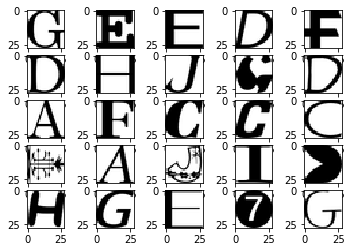

In [4]:
classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
X, y = read_dataset(image_dir, classes)
show_images(X)

In [5]:
Counter(y)

Counter({8: 52912,
         6: 52912,
         0: 52909,
         5: 52912,
         7: 52912,
         9: 52911,
         2: 52912,
         3: 52911,
         4: 52912,
         1: 52911})

In [6]:
def split_dataset(X, y, train_size, valid_size, test_size):
    train_index = train_size
    valid_index = train_index + valid_size
    test_index = valid_index + test_size
    random_indexes = np.random.permutation(X.shape[1])
    
    X_split = np.hsplit(X[:, random_indexes], [train_index, valid_index, test_index])
    y_split = np.hsplit(y[random_indexes], [train_index, valid_index, test_index])
    
    return X_split[0], X_split[1], X_split[2], y_split[0], y_split[1], y_split[2]

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, 200000, 10000, 19000)

In [8]:
def remove_duplicates(X, y, X_read_only):
    X_t = X.T
    X_read_only_t = X_read_only.T

    x_hashes = np.array([hashlib.sha256(img).hexdigest() for img in X_t])
    x_read_only_hashes = np.array([hashlib.sha256(img).hexdigest() for img in X_read_only_t])

    indexes_to_remove = []
    for i, h in enumerate(x_hashes):
        duplicates = np.where(x_read_only_hashes == h)
        if len(duplicates[0]):
            indexes_to_remove.append(i)

    print("Removed {} duplicates".format(len(indexes_to_remove)))

    if len(indexes_to_remove):
        return np.delete(X_t, indexes_to_remove, 0).T, np.delete(y, indexes_to_remove, 0)

    return X, y

In [9]:
X_train, y_train = remove_duplicates(X_train, y_train, X_val)
X_train, y_train = remove_duplicates(X_train, y_train, X_test)

Removed 3651 duplicates
Removed 2239 duplicates


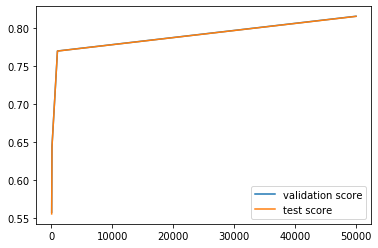

In [10]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

val_scores, test_scores = [], []
train_sizes = [50, 100, 1000, 50000]

for size in train_sizes:
    model = OneVsRestClassifier(LogisticRegression(solver = 'sag')).fit(X_train[:, :size].T, y_train[:size])
    val_scores.append(model.score(X_val.T, y_val))
    test_scores.append(model.score(X_test.T, y_test))

plt.plot(train_sizes, val_scores, label="validation score")
plt.plot(train_sizes, test_scores, label="test score")
plt.legend()
plt.show()